### Predict Response Time with Michael's Accessibility Score

---

* Objective: 
  * Does Accessibility matter when predicting response time?

* Notes/Scope
 * Make sure I aggregate features
 * Use Michaels v4 data
---
* __author__: Eric 
* __credits__: Michael & Jude
* __status__: Development

In [1]:
#packages

import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import numpy as np
import matplotlib as plt

import warnings
import sqlite3

from sklearn import preprocessing
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn import metrics
from xgboost.sklearn import XGBRegressor
from sklearn.metrics import accuracy_score

# hide warnings
warnings.filterwarnings('ignore')

In [2]:
# improvement from earlier process and use code Jude wrote to connect to v4 data


def create_connection(path):
    connection = None 
    connection = sqlite3.connect(path)
    connection.text_factory = str

    return connection

In [3]:

##Update this, its probably not where your DB is
con = create_connection('/Users/ericfitchwell/Downloads/fire_data_v4.db')

In [4]:

cur = con.cursor()

df = pd.read_sql("select calls_for_service.call_number " \
        ", calls_for_service.incident_number " \
        ", floating_catchment_output.[index] " \
        ", floating_catchment_output.zone_idx " \
        ", floating_catchment_output.accessibility_score " \
        ", floating_catchment_output.scenario_name " \
        ", calls_for_service.on_scene_dttm " \
        ", calls_for_service.response_dttm   " \
        ",calls_for_service.zipcode_of_incident"         
        ", category_mappings.[index] as primary_situation_index " \
        "from floating_catchment_output " \
        "inner join zone_idx_to_incident on  " \
        "zone_idx_to_incident.zone_idx = floating_catchment_output.zone_idx " \
        "inner join calls_for_service on calls_for_service.incident_number = zone_idx_to_incident.incident_number " \
        "left join fire_incidents AS fi on calls_for_service.incident_number = fi.incident_number " \
        "left join category_mappings on fi.primary_situation = category_mappings.primary_situation " \
        "where calls_for_service.unit_type in ('TRUCK', 'ENGINE') " \
        "and scenario_name = 'baseline'",con = con)

In [5]:
df2 = pd.read_sql('''select  
        zipcode,
        incident_number,
            battalion, station_area, ems_units, number_of_alarms,
            substr(primary_situation,1,3) as primary_situation_code,
            action_taken_primary, substr(property_use,1,3) as prop_code,
            neighborhood_district, supervisor_district, structure_type,
            area_of_fire_origin,detector_type,detector_operation
            
            
        from fire_incidents 


        where incident_date between '2019-01-01' and '2020-01-01'
         
        ''',
                  con=con)

In [6]:

#credits jude
df['on_scene_dttm'] = pd.to_datetime(df['on_scene_dttm'])
df['response_dttm'] = pd.to_datetime(df['response_dttm'])
df['arrival_time'] = (df['on_scene_dttm'] - df['response_dttm'])
df['minutes'] = (df.arrival_time.dt.seconds) / 60
df['seconds'] = (df.arrival_time.dt.seconds)


# add some features


df['date'] = df['on_scene_dttm'].dt.date
df['date'] = pd.to_datetime(df['date'])
df['day_of_week'] = df['on_scene_dttm'].dt.day_name().astype(str)
df['dayflag'] = (df.on_scene_dttm.dt.hour > 5) & (df.on_scene_dttm.dt.hour <18)
df['week_number'] = df['on_scene_dttm'].dt.week
df['day_of_month'] = df['on_scene_dttm'].dt.day
df['year'] = df['on_scene_dttm'].dt.year

# holiday check
cal = calendar()
dt = pd.date_range(start=df['date'].min(), end=df['date'].max())
holidays = cal.holidays(start=dt.min(), end=dt.max())

df['holiday_flag'] = df['date'].isin(holidays)

In [7]:
df.head()

,call_number,incident_number,index,zone_idx,accessibility_score,scenario_name,on_scene_dttm,response_dttm,zipcode_of_incident,primary_situation_index,arrival_time,minutes,seconds,date,day_of_week,dayflag,week_number,day_of_month,year,holiday_flag
0,190012684,19000313,0,8,0.000803,baseline,2019-01-01 16:25:28,2019-01-01 16:22:21,94121.0,NaN,0 days 00:03:07,3.116667,187.0,2019-01-01,Tuesday,True,1.0,1.0,2019.0,True
1,190012684,19000313,0,8,0.000803,baseline,2019-01-01 16:23:04,2019-01-01 16:18:06,94121.0,NaN,0 days 00:04:58,4.966667,298.0,2019-01-01,Tuesday,True,1.0,1.0,2019.0,True
2,190022379,19000734,0,8,0.000803,baseline,2019-01-02 15:35:57,2019-01-02 15:31:21,94121.0,NaN,0 days 00:04:36,4.600000,276.0,2019-01-02,Wednesday,True,1.0,2.0,2019.0,False
3,190053013,19002138,0,8,0.000803,baseline,2019-01-05 20:41:37,2019-01-05 20:40:16,94121.0,NaN,0 days 00:01:21,1.350000,81.0,2019-01-05,Saturday,False,1.0,5.0,2019.0,False
4,190060098,19002211,0,8,0.000803,baseline,2019-01-06 00:54:34,2019-01-06 00:52:49,94121.0,148.0,0 days 00:01:45,1.750000,105.0,2019-01-06,Sunday,False,1.0,6.0,2019.0,False


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137437 entries, 0 to 137436
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype          
---  ------                   --------------   -----          
 0   call_number              137437 non-null  int64          
 1   incident_number          137437 non-null  int64          
 2   index                    137437 non-null  int64          
 3   zone_idx                 137437 non-null  int64          
 4   accessibility_score      137437 non-null  float64        
 5   scenario_name            137437 non-null  object         
 6   on_scene_dttm            110692 non-null  datetime64[ns] 
 7   response_dttm            134246 non-null  datetime64[ns] 
 8   zipcode_of_incident      137437 non-null  object         
 9   primary_situation_index  50430 non-null   float64        
 10  arrival_time             110692 non-null  timedelta64[ns]
 11  minutes                  110692 non-null  float64        
 12  se

In [9]:
df3 = df.merge(df2,on='incident_number',how='inner')

In [10]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33106 entries, 0 to 33105
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   zipcode                 33086 non-null  object 
 1   incident_number         33106 non-null  int64  
 2   battalion               33106 non-null  object 
 3   station_area            33103 non-null  object 
 4   ems_units               33106 non-null  int64  
 5   number_of_alarms        33106 non-null  int64  
 6   primary_situation_code  33106 non-null  object 
 7   action_taken_primary    33106 non-null  object 
 8   prop_code               32963 non-null  object 
 9   neighborhood_district   33084 non-null  object 
 10  supervisor_district     16647 non-null  float64
 11  structure_type          269 non-null    object 
 12  area_of_fire_origin     1173 non-null   object 
 13  detector_type           129 non-null    object 
 14  detector_operation      129 non-null  

In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 60017 entries, 0 to 60016
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype          
---  ------                   --------------  -----          
 0   call_number              60017 non-null  int64          
 1   incident_number          60017 non-null  int64          
 2   index                    60017 non-null  int64          
 3   zone_idx                 60017 non-null  int64          
 4   accessibility_score      60017 non-null  float64        
 5   scenario_name            60017 non-null  object         
 6   on_scene_dttm            48785 non-null  datetime64[ns] 
 7   response_dttm            59096 non-null  datetime64[ns] 
 8   zipcode_of_incident      60017 non-null  object         
 9   primary_situation_index  50454 non-null  float64        
 10  arrival_time             48785 non-null  timedelta64[ns]
 11  minutes                  48785 non-null  float64        
 12  seconds           

In [12]:
def narrow_df(df):
    
    cols = ['zone_idx', 'accessibility_score','zipcode_of_incident','minutes',
           'day_of_week','dayflag', 'week_number','holiday_flag','battalion',
           'station_area', 'ems_units','number_of_alarms','primary_situation_code',
           'prop_code', 'neighborhood_district','supervisor_district',
           'structure_type','area_of_fire_origin']
            
        #drop variable many nulls
            #'detector_type','detector_operation'
    
    df = df[df['minutes'].notna()]
    
    return df[cols]

In [13]:
df4 = narrow_df(df3)

In [14]:
#rool up accessibility and minutes to zone, adapted Judes code

#pandas will drop na by default
df5 = df4.groupby(["zone_idx","zipcode_of_incident", "day_of_week","dayflag",
                    "week_number","holiday_flag","battalion",
                    "station_area","primary_situation_code",
                    "prop_code",
                    "neighborhood_district","supervisor_district",
                    "structure_type","area_of_fire_origin"],
                    as_index=False,dropna=False).agg({"accessibility_score":"median", "minutes":"median",
                                        "ems_units": "median", "number_of_alarms":"median"})

In [15]:
def split_data(df):
    """
    split data randomly with sklearn
    """
    X = df.loc[:,df.columns != 'minutes']
    y = df['minutes']
    
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)
    

    ############################### needs encoded
    lbl = preprocessing.LabelEncoder()
    
    X_train['day_of_week'] = lbl.fit_transform(X_train['day_of_week'].astype(str))
    X_train['battalion'] = lbl.fit_transform(X_train['battalion'].astype(str))
    X_train['prop_code'] = lbl.fit_transform(X_train['prop_code'].astype(str))
    X_train['neighborhood_district'] = lbl.fit_transform(X_train['neighborhood_district'].astype(str))
    X_train['structure_type'] = lbl.fit_transform(X_train['structure_type'].astype(str))
    X_train['area_of_fire_origin'] = lbl.fit_transform(X_train['area_of_fire_origin'].astype(str))
    
    X_train['zipcode_of_incident'] = lbl.fit_transform(X_train['zipcode_of_incident'].astype(str))
    X_train['station_area'] = lbl.fit_transform(X_train['station_area'].astype(str))
    X_train['primary_situation_code'] = lbl.fit_transform(X_train['primary_situation_code'].astype(str))
    
    X_test['day_of_week'] = lbl.fit_transform(X_test['day_of_week'].astype(str))
    X_test['battalion'] = lbl.fit_transform(X_test['battalion'].astype(str))
    X_test['prop_code'] = lbl.fit_transform(X_test['prop_code'].astype(str))
    X_test['neighborhood_district'] = lbl.fit_transform(X_test['neighborhood_district'].astype(str))
    X_test['structure_type'] = lbl.fit_transform(X_test['structure_type'].astype(str))
    X_test['primary_situation_code'] = lbl.fit_transform(X_test['primary_situation_code'].astype(str))
    
    X_test['zipcode_of_incident'] = lbl.fit_transform(X_test['zipcode_of_incident'].astype(str))
    X_test['station_area'] = lbl.fit_transform(X_test['station_area'].astype(str))
    X_test['area_of_fire_origin'] = lbl.fit_transform(X_test['area_of_fire_origin'].astype(str))
    ###############################
    
    return X_train, y_train, X_test, y_test

In [16]:
X_train, y_train, X_test, y_test = split_data(df5)

In [17]:
def run_model(X_train,y_train,X_test,y_test):
    
    model = XGBRegressor(max_depth=3,
                     n_estimators=500,
                     min_child_weight=2,
                     learning_rate=.3)
    
    
    model.fit(X_train,y_train,verbose=False)
    
    
    y_pred = model.predict(X_train)

    df_out = pd.DataFrame()

    df_out['preds'] = y_pred.astype(float)
    
    
    return df_out, model

In [18]:
a,b = run_model(X_train, y_train, X_test, y_test)

In [19]:
print('Train Results')
print('----------')
print('r2:', round(metrics.r2_score(y_train,a),2))
print('mae:', round(metrics.mean_absolute_error(y_train,a),2))
print('max error:', round(metrics.max_error(y_train,a),2))
print('mean sq error:', round(metrics.mean_squared_error(y_train,a),2))

Train Results
----------
r2: 0.89
mae: 1.37
max error: 277.16
mean sq error: 10.3


In [20]:
def show_importance(model,metric='weight'):
    """
    
    show feature importance by metric interested in, see xgboost docs for more
    
    """
    feature_important = model.get_booster().get_score(importance_type=metric)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    
    return data.plot(kind='barh')

[Text(0.5, 1.0, 'Feature Importance Training 2019 Model')]

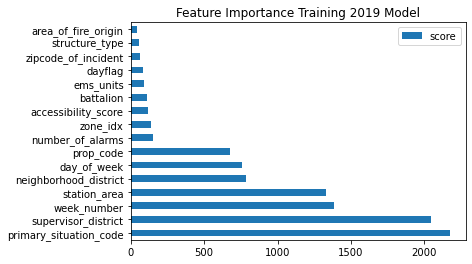

In [21]:
show_importance(b,'gain').set(title='Feature Importance Training 2019 Model')

In [22]:
# leverage Judes work, predict on michaels sim using classifier above
scenario_name = "baseline"
df_to_predict = pd.read_sql(('select zone_idx, accessibility_score from floating_catchment_output where scenario_name = ?'), con=con,params=[scenario_name])
df_to_predict.head()

,zone_idx,accessibility_score
0,8,0.000803
1,9,0.001147
2,10,0.000968
3,11,0.000501
4,12,0.000501
